# Snapshot Ensembles experiments

### Построим ансамбль моделей для классификации MNIST, воспользовавшись концепцией 'Train 1, get M for free', описанной в статье https://arxiv.org/abs/1704.00109

![title](1.png)

### В стандартном подходе модель заканчивает обучение, сойдясь к некоторому локальному миинимуму (на рисунке слева). Для построения ансамбля весь процесс обучения несколько раз с нуля.

### Авторы Snapshot Ensembling используют циклический лернинг рейт, что позволяет модели посетить несколько различных локальных минимумов на протяжении обучения (на рисунке справа).  В этих точках сохраняются "слепки" модели, которые будут использоваться на тесте для построения ансамбля.

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1


env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt

import os
import blosc

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append("..")

from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from ensemble_batch import MnistBatch
from ensemble_batch import draw_stats

## Загрузим данные MNIST

In [3]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

## Обучим модель на протяжении 2000 итераций с периодическим лернинг рейтом:

\begin{align}
\alpha(t) = \frac{\alpha_0}{2} \left( \cos \left( \frac{\pi mod(t-1, [T/M])}{[T/M]} \right) + 1 \right) \in [\alpha_0, 0]
\end{align}

## И сохраним $m$ промежуточных моделей на диск

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
stats = []
loss_history = []
train_stats = []
train_loss_history = []

In [5]:
alpha = 0.001
period = 300
n_iterations = 1501

In [6]:
# pipeline for train
ppl = (mnistset.train.pipeline().
       load(src=src, fmt='ndarray').
       train_convy(sess,  alpha, period, n_iterations, train_stats, train_loss_history))

# pipeline for test
ppl_test = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            update_stats(sess, stats, loss_history))

In [7]:
for i in tqdm(range(n_iterations)):
    ppl.next_batch(100, n_epochs=None)
    if i % 50 == 0:
        ppl_test.next_batch(300, n_epochs=None)
    if i % 501 == 0:
        print(i, 'current stat', stats[-10:])

  0%|                                                                                         | 0/1501 [00:00<?, ?it/s]

0 current stat [0.1]


 20%|███████████████▊                                                               | 300/1501 [01:08<05:49,  3.44it/s]

hey


 33%|██████████████████████████▎                                                    | 501/1501 [02:22<07:06,  2.34it/s]

501 current stat [0.64333332, 0.83666664, 0.87333333, 0.9066667, 0.94, 0.94, 0.93333334, 0.95666665, 0.92666668, 0.95333332]


 40%|███████████████████████████████▌                                               | 600/1501 [03:05<07:28,  2.01it/s]

hey


 60%|███████████████████████████████████████████████▎                               | 900/1501 [05:59<06:12,  1.61it/s]

hey


 67%|████████████████████████████████████████████████████                          | 1002/1501 [07:15<05:48,  1.43it/s]

1002 current stat [0.94333333, 0.94666666, 0.94999999, 0.96666664, 0.97000003, 0.96666664, 0.95999998, 0.94666666, 0.94333333, 0.96666664]


 80%|██████████████████████████████████████████████████████████████▎               | 1200/1501 [09:42<03:47,  1.32it/s]

hey


100%|█████████████████████████████████████████████████████████████████████████████▉| 1500/1501 [14:21<00:00,  1.06it/s]

hey


100%|██████████████████████████████████████████████████████████████████████████████| 1501/1501 [14:36<00:00,  5.34s/it]


## Loss на валидации с 200-ой итерации:

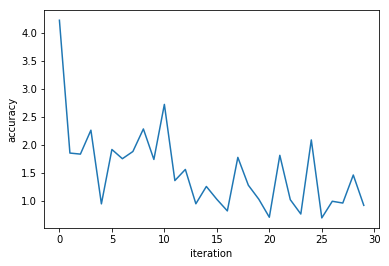

In [9]:
draw_stats(loss_history[1:], '')

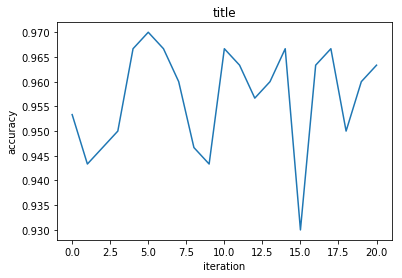

In [11]:
plt.title('title')
plt.plot(stats[10:] )
# for i in range(7):
#     plt.axvline(x=i*10, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

## Для получения результатов ансамбля $m$ моделей, загрузим сохраненные модели и усредним выходы $softmax$ слоев каждой модели

In [12]:
config = {}
config['period'] = period
config['n_iterations'] = n_iterations


In [13]:
ensemble_stats = []
ensemble_loss_history = []

# pipeline for ensemble test
ppl_ens_test = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            update_stats_ensemble(config, ensemble_stats, ensemble_loss_history))

In [14]:
for i in tqdm(range(50)):
    ppl_ens_test.next_batch(1000, n_epochs=None)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

i do hardcoding of n_iterations and period
currently loading trained+300/model-300.meta
INFO:tensorflow:Restoring parameters from trained+300/model-300
currently loading trained+600/model-600.meta
INFO:tensorflow:Restoring parameters from trained+600/model-600
currently loading trained+900/model-900.meta
INFO:tensorflow:Restoring parameters from trained+900/model-900
currently loading trained+1200/model-1200.meta
INFO:tensorflow:Restoring parameters from trained+1200/model-1200
currently loading trained+1500/model-1500.meta
INFO:tensorflow:Restoring parameters from trained+1500/model-1500


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder', defined at:
  File "C:\Users\Dari\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dari\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dari\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Dari\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Dari\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Dari\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Dari\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Dari\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-7a731bf2e613>", line 2, in <module>
    ppl_ens_test.next_batch(1000, n_epochs=None)
  File "..\dataset\dataset\pipeline.py", line 708, in next_batch
    batch_res = next(self._batch_generator)
  File "..\dataset\dataset\pipeline.py", line 684, in gen_batch
    batch_res = self._exec(batch)
  File "..\dataset\dataset\pipeline.py", line 437, in _exec
    batch_res = self._exec_all_actions(batch)
  File "..\dataset\dataset\pipeline.py", line 421, in _exec_all_actions
    batch = self._exec_one_action(batch, _action, _action_args, _action['kwargs'])
  File "..\dataset\dataset\pipeline.py", line 376, in _exec_one_action
    batch = action_method(*args, **kwargs)
  File "..\dataset\dataset\decorators.py", line 292, in _action_wrapper
    _model_spec = _model_method()
  File "..\dataset\dataset\decorators.py", line 245, in _model_wrapper
    model_spec = method(*args)
  File "C:\Users\Dari\Documents\az_training\task_06\ensemble_batch.py", line 272, in ensemble
    new_saver = tf.train.import_meta_graph(address)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1686, in import_meta_graph
    **kwargs)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\tensorflow\python\framework\meta_graph.py", line 504, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\tensorflow\python\framework\importer.py", line 311, in import_graph_def
    op_def=op_def)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Dari\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [26]:
В итоге лосс ансамбля моделей (после красной черты) действительно 

0.93611997

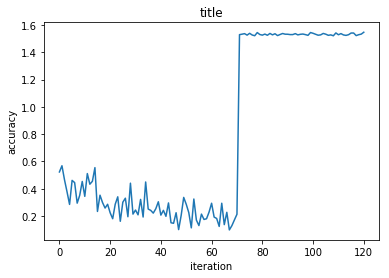

In [30]:
plt.title('title')
plt.plot(loss_history[10:] + ensemble_loss_history)
# plt.axvline(x=1801, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

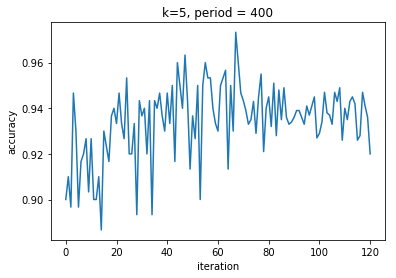

In [34]:
draw_stats(stats[10:] + ensemble_stats, 'k=5, period = 400')

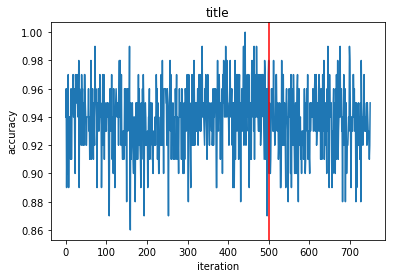

In [37]:
plt.title('title')
plt.plot(stats[1500:] + ensemble_stats)
plt.axvline(x=500, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [9]:
ensemble_loss_history[-2:]

NameError: name 'ensemble_loss_history' is not defined

In [1]:
draw_stats(stats[800:] + ensemble_stats, '')

NameError: name 'draw_stats' is not defined

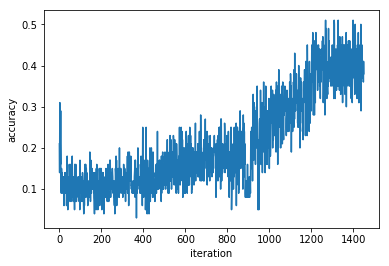

In [20]:
draw_stats(stats[800:] + ensemble_stats, '')

In [19]:
np.mean(ensemble_stats)

0.39635998

In [23]:
np.mean(stats[1400:])

0.22064891

In [2]:
stats[-2]

NameError: name 'stats' is not defined